<a href="https://colab.research.google.com/github/mewilke/GI-diagnosis/blob/main/GI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Gastrointestinal Disease Dataset AI Analysis
M. E. Wilke

This software analyzes a dataset linking 36 features of health data to various
gastrointestinal disease states. The dataset can be found at

https://www.kaggle.com/datasets/amanik000/gastrointestinal-disease-dataset

Note: The target disease states were replaced with random symptoms on Kaggle. The main signal found below is that the data are grouped into 4 clusters despite there being 6 balanced target classes. The accuracy of predictions is at the level of noise (1/6 target classes = 0.17).

In [1]:
# update Scikit Learn and install SciKeras
!pip install -q scikit-learn==1.7.2
!pip install -q scikeras

# dataframe manipulation
import pandas as pd
import numpy as np
import time

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# clustering
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN
from scipy.linalg import svd
from sklearn.neighbors import KNeighborsClassifier

# decision trees for classification
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_halving_search_cv # required to import HalvingGridSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV
import graphviz as gv
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# classification
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# upload the dataset and check for duplicate rows
df = pd.read_csv('./data/gastrointestinal_disease_dataset.csv')
num_duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicate_rows}")

Number of duplicate rows: 0


In [3]:
# examine the data
df.head()

,Age,Gender,BMI,Body_Weight,Obesity_Status,Ethnicity,Family_History,Genetic_Markers,Microbiome_Index,Autoimmune_Disorders,...,Rectal_Bleeding,Appetite_Loss,Weight_Loss,Bowel_Habits,Bowel_Movement_Frequency,NSAID_Use,Antibiotic_Use,PPI_Use,Medications,Disease_Class
0,9,Female,19.1,44.1,Normal,Black,0,9,0.25,1,...,1,1,1,Irregular,5,0,0,0,1,Unexplained weight loss
1,78,Male,38.2,121.0,Obese,White,1,10,0.27,1,...,0,1,0,Normal,4,0,1,1,1,Blood in stool
2,20,Male,34.2,79.0,Obese,Black,1,6,0.83,0,...,0,0,0,Frequent,0,1,0,0,0,Nausea or vomiting
3,73,Female,30.8,68.4,Obese,Asian,0,1,0.67,0,...,0,1,0,Infrequent,2,0,1,0,1,Nausea or vomiting
4,58,Male,26.4,66.7,Overweight,White,0,1,0.84,1,...,0,1,0,Normal,4,0,0,1,1,Unexplained weight loss


In [4]:
# Check for missing data
print(df.isnull().sum())

Age                         0
Gender                      0
BMI                         0
Body_Weight                 0
Obesity_Status              0
Ethnicity                   0
Family_History              0
Genetic_Markers             0
Microbiome_Index            0
Autoimmune_Disorders        0
H_Pylori_Status             0
Fecal_Calprotectin          0
Occult_Blood_Test           0
CRP_ESR                     0
Endoscopy_Result            0
Colonoscopy_Result          0
Stool_Culture               0
Diet_Type                   0
Food_Intolerance            0
Smoking_Status              0
Alcohol_Use                 0
Stress_Level                0
Physical_Activity           0
Abdominal_Pain              0
Bloating                    0
Diarrhea                    0
Constipation                0
Rectal_Bleeding             0
Appetite_Loss               0
Weight_Loss                 0
Bowel_Habits                0
Bowel_Movement_Frequency    0
NSAID_Use                   0
Antibiotic

There are no missing data.

Understand the types of data contained in each feature and the target. For instance Age is continuous while gender is a Boolean and Ethnicity is categorical.

In [5]:
# number of unique values for each feature and the target
print(df.nunique().to_frame(name='nunique'))

                          nunique
Age                            86
Gender                          2
BMI                           241
Body_Weight                  1129
Obesity_Status                  4
Ethnicity                       5
Family_History                  2
Genetic_Markers                11
Microbiome_Index              101
Autoimmune_Disorders            2
H_Pylori_Status                 2
Fecal_Calprotectin            501
Occult_Blood_Test               2
CRP_ESR                      1001
Endoscopy_Result                2
Colonoscopy_Result              2
Stool_Culture                   2
Diet_Type                       4
Food_Intolerance                2
Smoking_Status                  2
Alcohol_Use                     2
Stress_Level                   10
Physical_Activity               8
Abdominal_Pain                  2
Bloating                        2
Diarrhea                        2
Constipation                    2
Rectal_Bleeding                 2
Appetite_Loss 

Some algorithms require balanced target data to function properly. The target is sufficently balanced to proceed.

In [6]:
# Check that the target is balanced.
df['Disease_Class'].value_counts()

,count
Disease_Class,
Abdominal cramps or pain,5243
Blood in stool,5198
Nausea or vomiting,5118
Unexplained weight loss,5047
Diarrhea or constipation,4989
Bloating,4965


In [7]:
# simple view of number of unique values, min value, and max value
df_describe = df.describe()
df_nunique = df.nunique().to_frame(name='nunique')
combined_df = df_describe.T.merge(df_nunique, left_index=True, right_index=True, how='left')
print(combined_df[['nunique', 'min', 'max']])

                          nunique   min    max
Age                            86   5.0   90.0
BMI                           241  16.0   40.0
Body_Weight                  1129  27.2  144.4
Family_History                  2   0.0    1.0
Genetic_Markers                11   0.0   10.0
Microbiome_Index              101   0.0    1.0
Autoimmune_Disorders            2   0.0    1.0
H_Pylori_Status                 2   0.0    1.0
Fecal_Calprotectin            501   0.0  500.0
Occult_Blood_Test               2   0.0    1.0
CRP_ESR                      1001   0.0  100.0
Endoscopy_Result                2   0.0    1.0
Colonoscopy_Result              2   0.0    1.0
Stool_Culture                   2   0.0    1.0
Food_Intolerance                2   0.0    1.0
Smoking_Status                  2   0.0    1.0
Alcohol_Use                     2   0.0    1.0
Stress_Level                   10   1.0   10.0
Physical_Activity               8   0.0    7.0
Abdominal_Pain                  2   0.0    1.0
Bloating     

In [8]:
# Convert columns to numeric values

# One-hot encoding
df_dummies = pd.get_dummies(df, columns=['Ethnicity', 'Diet_Type', 'Bowel_Habits'], dtype='int8')

# Replace strings describing magnitudes with numbers
df_dummies['Obesity_Status'] = df_dummies['Obesity_Status'].replace({'Underweight':-1, 'Normal':0, 'Overweight':1, 'Obese':2}).astype('int8')
df_dummies['Gender'] = df_dummies['Gender'].replace({'Male':0, 'Female':1}).astype('int8')

# Define the dtypes for multiple columns to reduce memory usage. The smallest available int is int8.
# Continuous features may be squared and cubed later so leaving as int64 or float64
dtype_mapping = {
    'Family_History': 'int8',
    'Autoimmune_Disorders': 'int8',
    'H_Pylori_Status': 'int8',
    'Occult_Blood_Test': 'int8',
    'Endoscopy_Result': 'int8',
    'Colonoscopy_Result': 'int8',
    'Stool_Culture': 'int8',
    'Food_Intolerance': 'int8',
    'Smoking_Status': 'int8',
    'Alcohol_Use': 'int8',
    'Abdominal_Pain': 'int8',
    'Bloating': 'int8',
    'Diarrhea': 'int8',
    'Constipation': 'int8',
    'Rectal_Bleeding': 'int8',
    'Appetite_Loss': 'int8',
    'Weight_Loss': 'int8',
    'NSAID_Use': 'int8',
    'Antibiotic_Use': 'int8',
    'PPI_Use': 'int8',
    'Medications': 'int8'
}

# Apply the dtypes
df = df_dummies.astype(dtype_mapping)

# Encode the target classes
le = LabelEncoder()
df['Disease_Class'] = le.fit_transform(df['Disease_Class'])

In [9]:
# confirm the data type assignments
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30560 entries, 0 to 30559
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       30560 non-null  int64  
 1   Gender                    30560 non-null  int8   
 2   BMI                       30560 non-null  float64
 3   Body_Weight               30560 non-null  float64
 4   Obesity_Status            30560 non-null  int8   
 5   Family_History            30560 non-null  int8   
 6   Genetic_Markers           30560 non-null  int64  
 7   Microbiome_Index          30560 non-null  float64
 8   Autoimmune_Disorders      30560 non-null  int8   
 9   H_Pylori_Status           30560 non-null  int8   
 10  Fecal_Calprotectin        30560 non-null  int64  
 11  Occult_Blood_Test         30560 non-null  int8   
 12  CRP_ESR                   30560 non-null  float64
 13  Endoscopy_Result          30560 non-null  int8   
 14  Colono

In [10]:
# confirm the disease class encoding
df['Disease_Class'].head()

# uncomment to see the disease class strings
#le.inverse_transform(df['Disease_Class'])

,Disease_Class
0,5
1,2
2,4
3,4
4,5


##Correlation
"A correlation coefficient is a statistical measure ranging from -1 to +1 that quantifies the strength and direction of a linear relationship between two variables. A value of +1 indicates a perfect positive linear relationship, where both variables increase together, while -1 signifies a perfect negative linear relationship, where one variable's increase corresponds to the other's decrease. A value of 0 indicates no linear relationship."

The correlations are very low with the exception of correlations between some of the features. These higher correlations will be used to reduce the number of features used later.

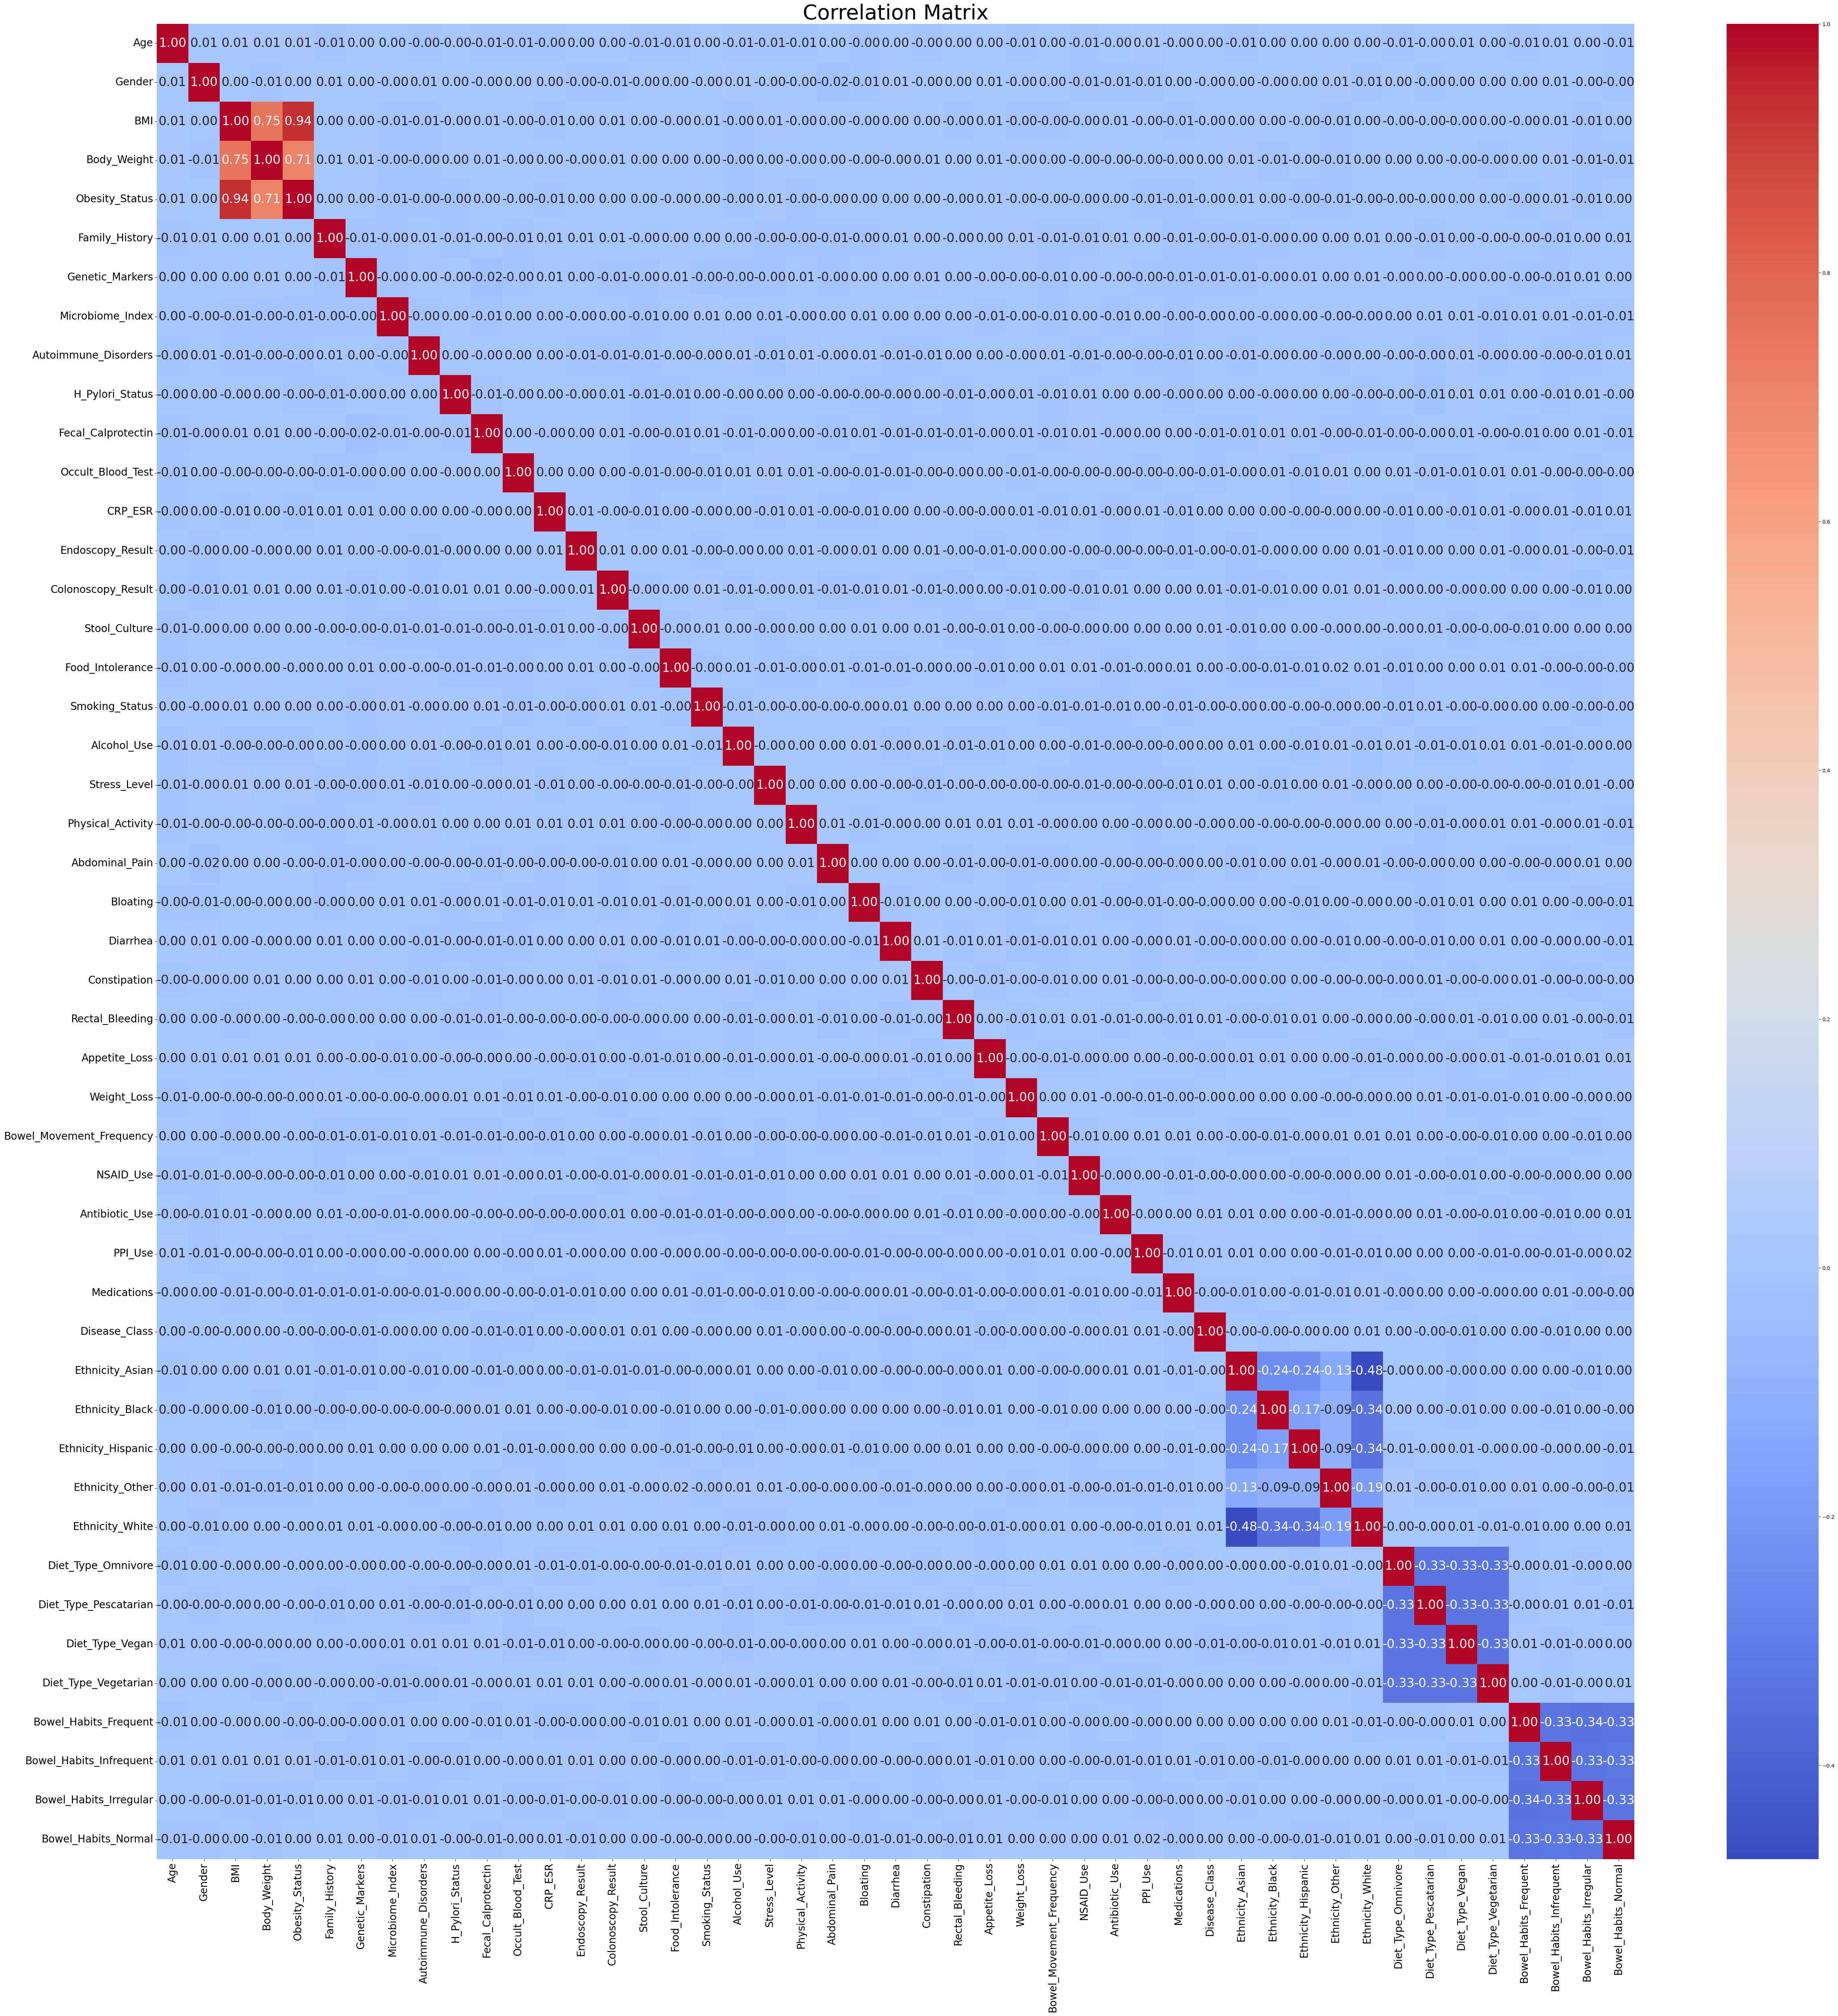

In [11]:
# Correlation Matrix
plt.figure(figsize=(64,64))
ax = sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f",  annot_kws={"size": 24})
plt.title('Correlation Matrix', fontsize=40)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.savefig('big_correlation_matrix.png')

##Train Test Split
The data are split into features and the target. These are then split into datasets
for training and testing. The test dataset is used for an unbiased evaluation of the
model's performance.

In [12]:
# Split the data into train and test datasets
X = df.drop('Disease_Class', axis=1)
y = df['Disease_Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##Principal Component Analysis
"Principal Component Analysis (PCA) is a statistical technique used to simplify complex, high-dimensional datasets by reducing their dimensionality while retaining the most important information. It works by transforming the original variables into a new set of uncorrelated variables called principal components, which are linear combinations of the original features. The principal components are ordered by the amount of variance they explain, allowing analysts to identify the key underlying patterns and visualize the data more effectively."

"SVD, or Singular Value Decomposition, is a mathematical technique that breaks down any matrix into three other matrices: two orthogonal matrices (U and V) and a diagonal matrix (sigma) containing the singular values. This powerful decomposition reveals the fundamental components of a matrix, making it useful for tasks like dimensionality reduction, where it identifies and retains the most important features of data, and image compression, by discarding less significant information to reduce file size."

The data must be normalized before running PCA. In this case, the normalization is done by adjusting the range of data to fall between 0 and 1 (Min-Max normalization).

###Plots
The singular value plotted against the singular value index is called a scree plot. The higher sigma values indicate the principal components. The index of the elbow indicates how many components are among the most important.

The percent singular value plotted against the index also presents an elbow that indicates the number of principal components.

The plots indicate there are about 4 to 8 principal components depending on the cuttoff chosen.

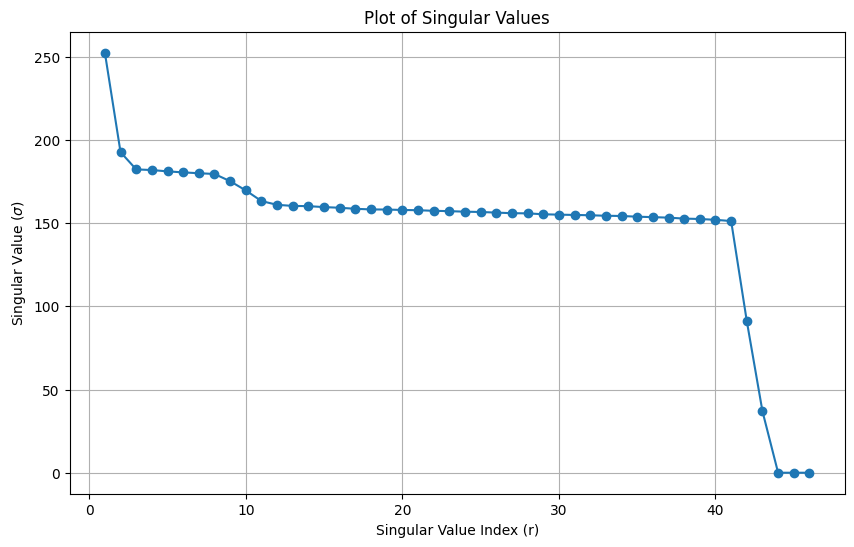

In [13]:
# Pricipal Component Analysis using SVD to aid with understanding clusters
# Normalize and run PCA using SVD
def svd_norm(X):
    x_norm =(X - X.mean())/X.std()
    U, sigma, VT = svd(x_norm, full_matrices=False)
    Sigma = np.diag(sigma)
    return U, Sigma, VT
U, Sigma, VT = svd_norm(X_train)

# Plot x = r and y = Sigma
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(Sigma) + 1), np.diag(Sigma), 'o-')
plt.title('Plot of Singular Values')
plt.xlabel('Singular Value Index (r)')
plt.ylabel('Singular Value ($\sigma$)')
plt.grid(True)
plt.savefig('PCA.png')

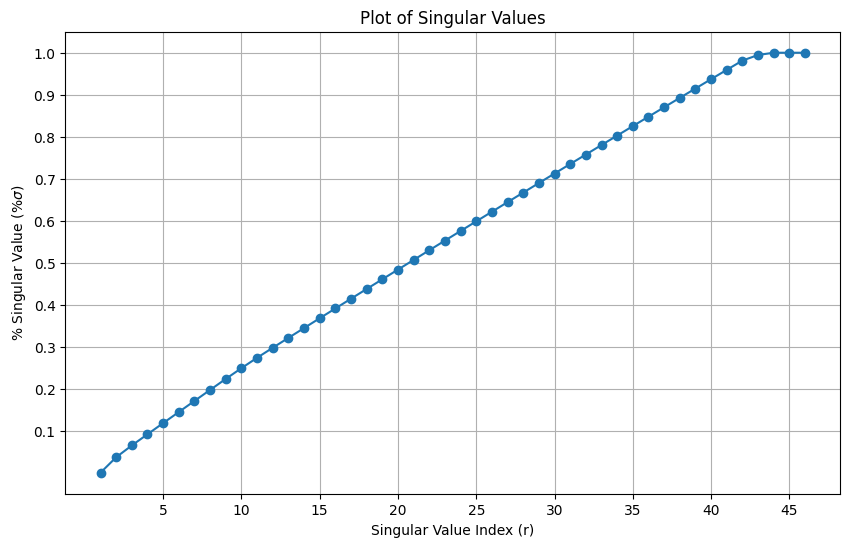

In [14]:
# Plot x = r and y = % Sigma
SigSum = []
for i in range(len(Sigma)):
  SigSum.append(np.diag(Sigma)[:i].sum())

plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(Sigma) + 1), SigSum/SigSum[-1], 'o-')
plt.title('Plot of Singular Values')
plt.xlabel('Singular Value Index (r)')
plt.ylabel('% Singular Value (%$\sigma$)')
plt.xticks([5, 10, 15, 20, 25, 30, 35, 40, 45])
plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.grid(True)
plt.savefig('percent_PCA.png')

#Feature Engineering
One type of feature engineering is used to reduce the number of features being used to the best features. The data need to be scaled. StandardScaler transforms the data so the mean of each feature is 0 and the standard deviation is 1.

LASSO (Least Absolute Shrinkage and Selection Operator) performs automatic feature selection by applying L1 regularization. L1 regularization adds a penalty term that shrinks some feature coefficients to zero, effectively removing those features from the model. This keeps only the most important features. It is expected that the number of features identified by SVD and/or PCA will be similar.

Six features are identified (see legend of the plot). However, as seen the the correlation matrices above and below, some of the features are closely correlated and can be eliminated leaving 4 features.

In [15]:
# Feature engineering

# Prepare to plot LASSO results by scaling the data
X_scaled = StandardScaler().fit_transform(X)

# Find best lambda (C) for LASSO
param_grid = {'C': np.logspace(-10, -0.00001, 46)}
lr = LogisticRegression(penalty='l1', solver='liblinear')
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_scaled, y)

best_C = grid_search.best_params_['C']
print(f"The best C is: {best_C}")

The best C is: 0.009999815794889151


In [16]:
# LASSO bracketing best C value
C = np.logspace(-0.01, -0.00001, 46)
coef = np.empty((len(C), 46))

for i, c in enumerate(C):
     lr = LogisticRegression(penalty='l1', C=c, solver='liblinear').fit(X_scaled, y)
     coef = lr.coef_

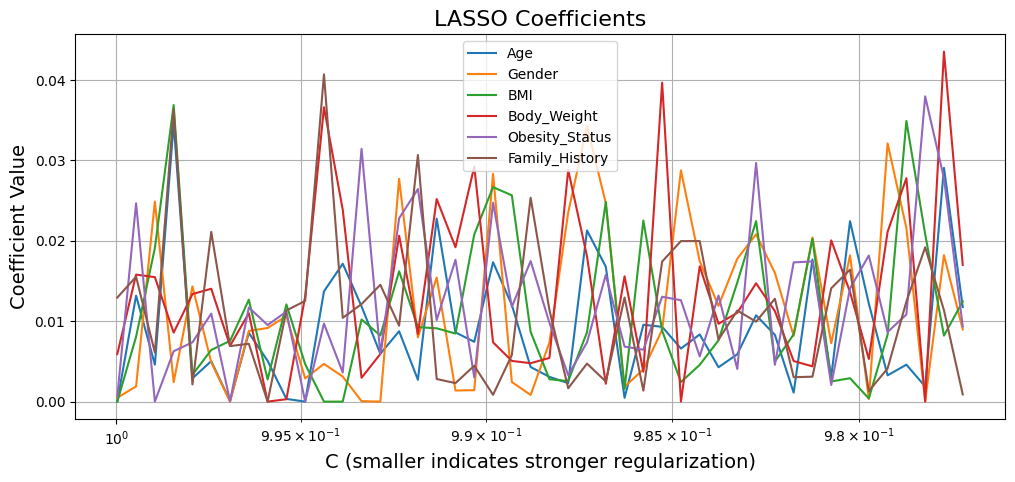

In [17]:
# plot of C values against coefficients from LASSO
plt.figure(figsize = (12, 5))

for i in range(coef.shape[0]):
    plt.semilogx(C, abs(coef[i, :]))

plt.gca().invert_xaxis()
plt.grid(which='both')
plt.legend(X_train.columns, fontsize=10)
plt.xlabel('C (smaller indicates stronger regularization)', fontsize=14)
plt.ylabel('Coefficient Value', fontsize=14)
plt.title('LASSO Coefficients', fontsize=16)
plt.savefig('LASSO.png')

##Correlation
Correlations can be used to identify closely related features for elimination.  Body_Weight will be kept while Obesity_Status and BMI will be dropped.

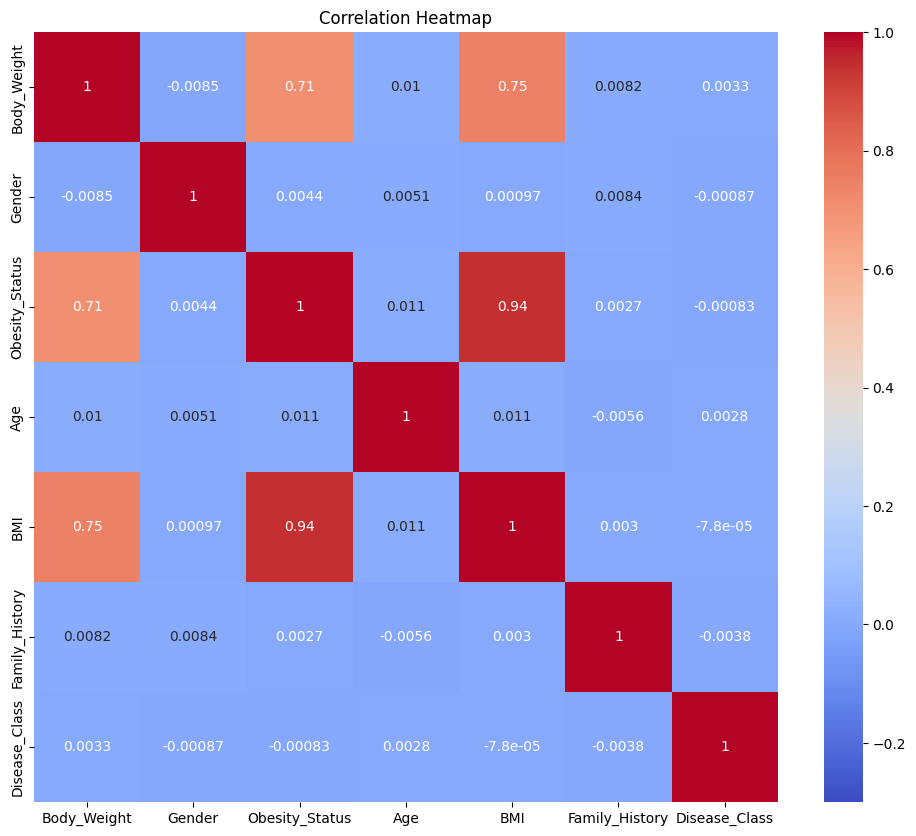

In [18]:
# Correlation heatmap
df_top_feats = df[['Body_Weight', 'Gender', 'Obesity_Status', 'Age', 'BMI', 'Family_History', 'Disease_Class']]

plt.figure(figsize=(12, 10))
sns.heatmap(df_top_feats.corr(), annot=True, cmap='coolwarm', vmin=-.3, vmax=1)
plt.title('Correlation Heatmap')
plt.savefig('small_correlation_matrix.png')

##Train Test Split
All but the top features are dropped. The data are split into features and the target. These are then split into datasets
for training and testing. The test dataset is used for an unbiased evaluation of the
model's performance.

In [19]:
# train_test_split using just the top features
df_top_feats = df[['Body_Weight', 'Gender', 'Age', 'Family_History', 'Disease_Class']]
X = df_top_feats.drop('Disease_Class', axis=1)
y = df_top_feats['Disease_Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##Pairplot
A pairplot is a convenient way to view the relationships of features to each other and to the target.

There are no patterns visible in the top features relative to each other or the target.

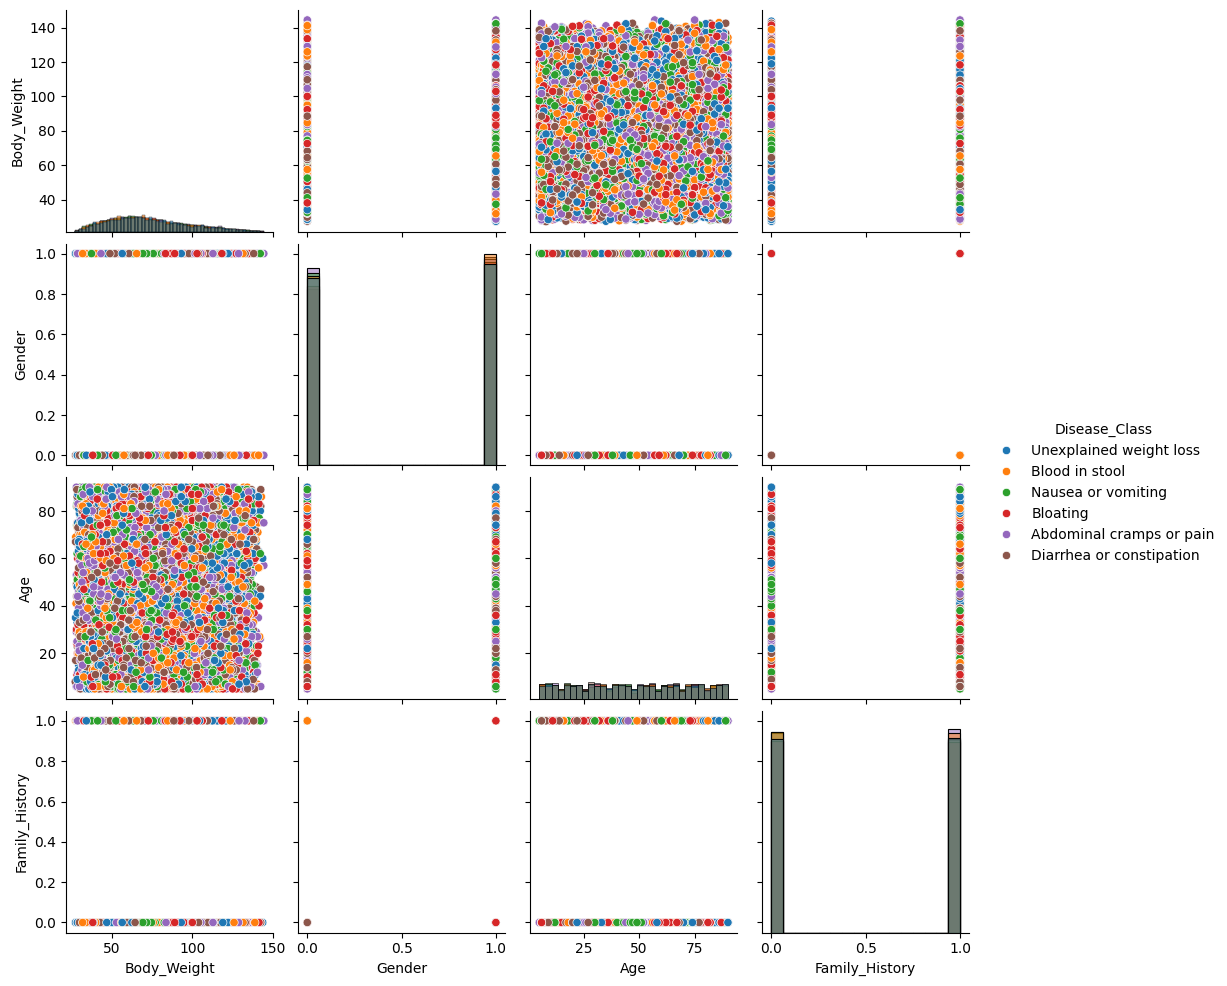

In [20]:
# Dropping BMI because it has a correlation of 0.94 with Obesity Status, 0.75 with Body Weight and -0.000078 with the target.
# Dropping Obesity Status because it has a correlation of 0.75 with Body Weight and .00083 with the target.
# Keeping Body_Weight because it has a correlation coefficient of 0.003 with the target.
# Pairplot of most relevant features based on LASSO and Correlation with the target.
df_top_feats_pair = df[['Body_Weight', 'Gender', 'Age', 'Family_History', 'Disease_Class']]
df_top_feats_pair['Disease_Class'] = le.inverse_transform(df['Disease_Class'])
sns.pairplot(df_top_feats_pair, hue='Disease_Class', diag_kind='hist')
plt.savefig('pairplot.png')

##Classification
There are several algorithms for breaking data into categories. The following algorithms are explored here:
####KNN (K-Nearest Neighbors)
KNN classifies a data point by finding the 'k' most similar neighboring data points in a training dataset and then assigning the test data points to the most frequent class among those 'k' neighbors. KNN is computationally expensive so only one iteration is run here.

####Decision Trees
A decision tree recursively partitions data into smaller subsets based on feature values, ultimately forming a tree-like structure to make predictions. At each split the algorithm chooses the best feature to split and then the best threshold value on which to split the data. The process is recursive.

####Random Forest
A random forest works by building individual decision trees, each trained on a  random subset of the data and features. It makes predictions by combining the individual tree outputs through majority voting for classification.

####Boosting
Boosting or boot strapping is an ensemble method that converts a group of weak models into a  stronger model by sequentially training models focusing on the mistakes of the previous models.

####Naive Bayes
The assumption that features are independent of each other (naive) is made to simplify the calculations. This is a good assumption if correlated features have been removed. The algorithn calculates the probability of observing the given features if the data point belongs to a specific class.

####Neural Network
A hardware accelerator is needed to run the neural net. run GI_neural_net.ipynb with the hardware accelerator selected.

A neural network is a type of AI model, inspired by the brain. It has interconnected nodes or "neurons" arranged in layers. These networks learn by adjusting weights and biases of the connections between neurons to recognize patterns and make predictions or decisions.

In this application a neural net is used for categorization. TabPFN was chosen because it is excels with small tabular datasets. Its "...transformer architecture learns a generic algorithm from a massive number of synthetic datasets, allowing it to make predictions on new data with a single forward pass (in-context learning) without requiring model retraining or extensive hyperparameter tuning."

##Train Test Split
The top features are split into train and test datasets. Note that the results with the full dataset are similar.

####KNN (K-Nearest Neighbors)

In [21]:
# Classification

# Create a dataframe to capture statistics of classification algorithms
statistics_df = pd.DataFrame(columns=['Algorithm', 'Accuracy', 'Precision', 'Recall', 'F1'])

# KNN: classification, new data compared to all training data is expensive.
start_time = time.time()
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

statistics_df.loc[0, 'Algorithm'] = 'KNN'
statistics_df.loc[0, 'Accuracy'] = accuracy_score(y_test, y_pred)
statistics_df.loc[0, 'Precision'] = precision_score(y_test, y_pred, average='weighted')
statistics_df.loc[0, 'Recall'] = recall_score(y_test, y_pred, average='weighted')
statistics_df.loc[0, 'F1'] = f1_score(y_test, y_pred, average='weighted')


end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")
statistics_df

Time taken: 0.08606934547424316 seconds


,Algorithm,Accuracy,Precision,Recall,F1
0,KNN,0.174084,0.167347,0.174084,0.157847


In [22]:
# tune number of neighbors for KNN to maximize accuracy
# takes about 3 hours wall time to run
#start_time = time.time()
#params = {'n_neighbors':np.array(range(1, len(y_train)))}
#model = KNeighborsClassifier()
#model_finder = GridSearchCV(
#    estimator=model,
#    param_grid=params,
#    scoring='accuracy',
#    cv=3) #decreased from 5 to reduce runtime
#model_finder.fit(X_train, y_train)
#est = model_finder.best_estimator_
#KNeighborsClassifier(n_neighbors=est)
#model_finder.cv_results_['mean_test_score']
#end_time = time.time()
#print(f"Time taken: {end_time - start_time} seconds")

####Decision Tree

In [23]:
# Decision Tree
params = {
    'max_depth': [1, 2, 3, 4],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [1, 2, 5]
}

# GridSearchCV
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(),
                           param_grid=params,
                           cv=5,
                           scoring='accuracy')
grid_search.fit(X_train, y_train)
print('GridSearchCV best score: ', grid_search.best_score_)
print(grid_search.best_params_)

# RandomizedSearchCV
grid_search = RandomizedSearchCV(estimator=DecisionTreeClassifier(),
                           param_distributions=params,
                           cv=5,
                           scoring='accuracy')
grid_search.fit(X_train, y_train)
print('RandomizedGridSearchCV best score: ', grid_search.best_score_)
print(grid_search.best_params_)

# HalvingGridSearchCV
grid_search = HalvingGridSearchCV(estimator=DecisionTreeClassifier(),
                           param_grid=params,
                           cv=5,
                           scoring='accuracy')
grid_search.fit(X_train, y_train)
print('HalvingGridSearchCV best score: ', grid_search.best_score_)
print(grid_search.best_params_)

# HalvingRandomSearchCV
grid_search = HalvingRandomSearchCV(estimator=DecisionTreeClassifier(),
                           param_distributions=params,
                           cv=5,
                           scoring='accuracy')
grid_search.fit(X_train, y_train)
print('HalvingRandomSearchCV best score: ', grid_search.best_score_)
print(grid_search.best_params_)

# mean_fit_time was not an issue.
# GridSearchCV gave the best score with DecisionTreeClassifier

GridSearchCV best score:  0.17019821217114
{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
RandomizedGridSearchCV best score:  0.17019821217114
{'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 3, 'criterion': 'entropy'}
HalvingGridSearchCV best score:  0.16694632296114037
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 10}
HalvingRandomSearchCV best score:  0.1718170699078852
{'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 1, 'criterion': 'entropy'}


In [24]:
# GridSearchCV
params = {
    'max_depth': [1, 2, 3],
    'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'criterion': ['entropy', 'gini'],
    'min_samples_leaf': [1, 2, 4, 8, 16]
}
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(),
                           param_grid=params,
                           cv=5,
                           scoring='accuracy')
grid_search.fit(X_train, y_train)
print('HalvingRandomSearchCV best score: ', grid_search.best_score_)
print(grid_search.best_params_)

HalvingRandomSearchCV best score:  0.17023912033231817
{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [25]:
# Decision Trees
decision_tree_model = DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_leaf=1, min_samples_split=2)
decision_tree_model.fit(X_train, y_train)

y_pred = decision_tree_model.predict(X_test)

statistics_df.loc[1, 'Algorithm'] = 'Decision Tree'
statistics_df.loc[1, 'Accuracy'] = accuracy_score(y_test, y_pred)
statistics_df.loc[1, 'Precision'] = precision_score(y_test, y_pred, average='weighted')
statistics_df.loc[1, 'Recall'] = recall_score(y_test, y_pred, average='weighted')
statistics_df.loc[1, 'F1'] = f1_score(y_test, y_pred, average='weighted')


statistics_df

,Algorithm,Accuracy,Precision,Recall,F1
0,KNN,0.174084,0.167347,0.174084,0.157847
1,Decision Tree,0.164921,0.12451,0.164921,0.098368


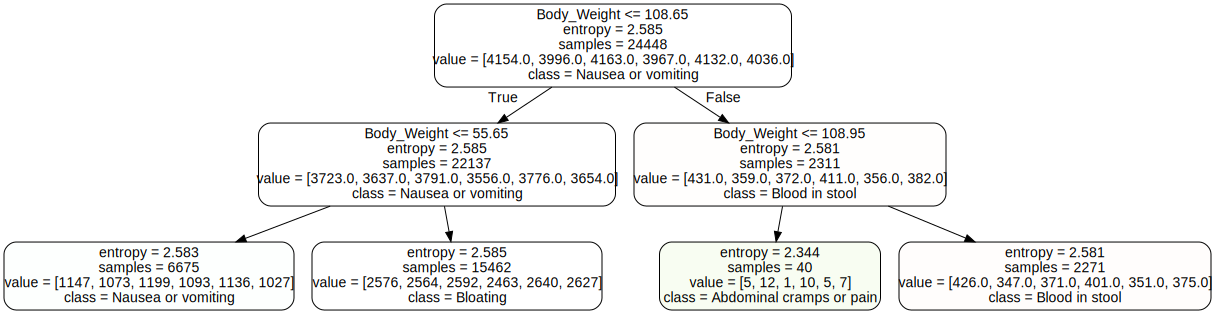

In [26]:
# plot decision tree
dot_data = tree.export_graphviz(decision_tree_model,
                                out_file=None,
                                feature_names=X_train.columns,
                                class_names=['Blood in stool', 'Abdominal cramps or pain', 'Nausea or vomiting', 'Unexplained weight loss', 'Bloating', 'Diarrhea or constipation'],
                                filled=True,
                                rounded=True)
graph = gv.Source(dot_data)
graph.render(format="png", filename="decision_tree")
graph

####Random Forest

In [27]:
# Random Forest
start_time = time.time()
model = RandomForestClassifier(n_estimators=1000, max_features=4, oob_score=True)
model.fit(X, y)
y_pred = model.predict(X_test)

print('OOB Score: ', model.oob_score_)
end_time = time.time()
print(f"Time taken: {(end_time - start_time)/60} minutes\n")

OOB Score:  0.17149869109947644
Time taken: 2.0457364598910015 minutes



In [28]:
# Tuning max_features for RandomForestClassifier
# Takes about 2 minutes wall time to run
start_time = time.time()
params = {'max_features': [1, 2, 3, 4],
          'n_estimators': [100],
          'oob_score': [True]}
grid_search = GridSearchCV(estimator=RandomForestClassifier(),
                           param_grid=params,
                           cv=5,
                           scoring='accuracy')
grid_search.fit(X_train, y_train)
end_time = time.time()
print('GridSearchCV best score: ', grid_search.best_score_)
print(grid_search.best_params_)
print(f"Time taken: {(end_time - start_time)/60} minutes")

GridSearchCV best score:  0.1680302636735947
{'max_features': 1, 'n_estimators': 100, 'oob_score': True}
Time taken: 2.1334815502166746 minutes


In [29]:
# Running RandomForestClassifier with max_features tuned
# Takes about 2 minutes wall time to run
start_time = time.time()
model = RandomForestClassifier(n_estimators=1000, max_features=1, oob_score=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

statistics_df.loc[2, 'Algorithm'] = 'Random Forest'
statistics_df.loc[2, 'Accuracy'] = accuracy_score(y_test, y_pred)
statistics_df.loc[2, 'Precision'] = precision_score(y_test, y_pred, average='weighted')
statistics_df.loc[2, 'Recall'] = recall_score(y_test, y_pred, average='weighted')
statistics_df.loc[2, 'F1'] = f1_score(y_test, y_pred, average='weighted')

print('Out-of-Bag (OOB) Score : ', model.oob_score_)
end_time = time.time()
print(f"Time taken: {(end_time - start_time)/60} minutes", '\n')
statistics_df

Out-of-Bag (OOB) Score :  0.17019797120418848
Time taken: 0.9360406676928202 minutes 



,Algorithm,Accuracy,Precision,Recall,F1
0,KNN,0.174084,0.167347,0.174084,0.157847
1,Decision Tree,0.164921,0.12451,0.164921,0.098368
2,Random Forest,0.174247,0.174667,0.174247,0.174307


####Boosting

In [30]:
# Boosting using XGBoost
model = xgb.XGBClassifier(objective='multi:softmax',
                          num_class=6,
                          n_estimators=100,
                          learning_rate=0.2,
                          use_label_encoder=False, # Suppress warning for older versions
                          eval_metric='logloss'
                         )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

statistics_df.loc[3, 'Algorithm'] = 'Boosting'
statistics_df.loc[3, 'Accuracy'] = accuracy_score(y_test, y_pred)
statistics_df.loc[3, 'Precision'] = precision_score(y_test, y_pred, average='weighted')
statistics_df.loc[3, 'Recall'] = recall_score(y_test, y_pred, average='weighted')
statistics_df.loc[3, 'F1'] = f1_score(y_test, y_pred, average='weighted')

statistics_df

,Algorithm,Accuracy,Precision,Recall,F1
0,KNN,0.174084,0.167347,0.174084,0.157847
1,Decision Tree,0.164921,0.12451,0.164921,0.098368
2,Random Forest,0.174247,0.174667,0.174247,0.174307
3,Boosting,0.159031,0.158873,0.159031,0.158491


####Naive Bayes

In [32]:
# Naive Bayes
Disease_Class_df = pd.DataFrame(le.inverse_transform(df['Disease_Class']))
naive_bayes = MultinomialNB(alpha=1.0, fit_prior=False).fit(X_train, y_train)
naive_df = pd.DataFrame(naive_bayes.feature_log_prob_, columns=X_train.columns)
y_pred = naive_bayes.predict(X_test)

statistics_df.loc[4, 'Algorithm'] = 'Naive Bayes'
statistics_df.loc[4, 'Accuracy'] = accuracy_score(y_test, y_pred)
statistics_df.loc[4, 'Precision'] = precision_score(y_test, y_pred, average='weighted')
statistics_df.loc[4, 'Recall'] = recall_score(y_test, y_pred, average='weighted')
statistics_df.loc[4, 'F1'] = f1_score(y_test, y_pred, average='weighted')

# each row corresponds to a class in the target, and each column corresponds to a feature
naive_df


,Body_Weight,Gender,Age,Family_History
0,-0.507289,-5.461731,-0.943103,-5.470209
1,-0.507886,-5.416463,-0.942603,-5.477791
2,-0.515287,-5.430038,-0.930984,-5.491315
3,-0.511433,-5.406763,-0.937103,-5.492682
4,-0.510909,-5.454801,-0.937270,-5.501993
5,-0.504637,-5.455063,-0.947108,-5.487135


In [33]:
statistics_df

,Algorithm,Accuracy,Precision,Recall,F1
0,KNN,0.174084,0.167347,0.174084,0.157847
1,Decision Tree,0.164921,0.12451,0.164921,0.098368
2,Random Forest,0.174247,0.174667,0.174247,0.174307
3,Boosting,0.159031,0.158873,0.159031,0.158491
4,Naive Bayes,0.167212,0.175197,0.167212,0.105742


In [34]:
# Evaluate all the different models
print('Maximum Accuracy: ', statistics_df['Accuracy'].max())
print('Maximum Precision: ', statistics_df['Precision'].max())
print('Maximum Recall: ', statistics_df['Recall'].max())
print('Maximum F1: ', statistics_df['F1'].max())

Maximum Accuracy:  0.1742473821989529
Maximum Precision:  0.17519711088505238
Maximum Recall:  0.1742473821989529
Maximum F1:  0.17430697226201886


##Train Test Split
The data are split into features and the target. These are then split into datasets
for training and testing. The test dataset is used for an unbiased evaluation of the
model's performance.

In [35]:
# Split the data into train and test datasets
X = df.drop('Disease_Class', axis=1)
y = df['Disease_Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##Clustering
Because the feature data do not predict the target data in this dataset, clustering is being explored to see how many groups of symptom features there are in the data.

###K-means Clustering
"K-means clustering is an unsupervised machine learning algorithm that divides a dataset into a pre-specified number of clusters, or groups (K). The algorithm works iteratively by assigning data points to the nearest cluster centroid and then recalculating the centroids as the mean of the points in each cluster. The process repeats until the centroids stabilize, aiming to minimize the within-cluster sum of squares (making clusters internally similar) and maximize the between-cluster sum of squares (making clusters dissimilar)."

"In K-means clustering, inertia is a metric used to evaluate the quality of the clustering. It is also known as the Within-Cluster Sum of Squares (WCSS)." The elbow in a plot of inertia against the number of clusters indicates the best number of clusters.

K-means indicates there are actually 4 clusters in the dataset rather than the 6 target values.

In [36]:
# Clustering of disease class using K-means
X = np.array(df)
inertias = []
for i in range(2, 11):
  kmeans = KMeans(n_clusters=i, random_state=42).fit(X)
  inertias.append(kmeans.inertia_/1000000) # divide by 1000000 to make results easier to interpret
print(inertias)

[225.24636004953572, 135.82217511895715, 104.80035691759628, 90.53435993324172, 82.8070387972471, 79.2709140207583, 74.82304026008563, 71.7642778000217, 69.53208569107942]


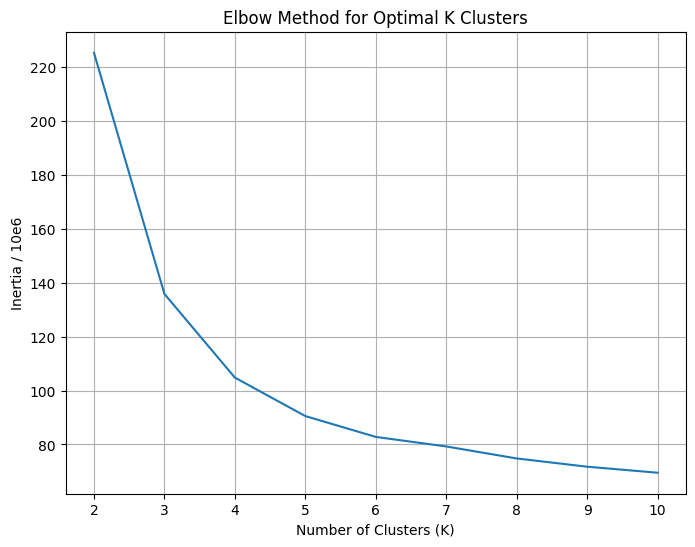

In [37]:
inertias = pd.DataFrame(inertias)
inertias = inertias.rename(columns={0:'Inertia/10e6'})
inertias.index.name = 'Number of Clusters'
inertias.index += 2 # range of clusters is 2 to 11

# Plot inertias
plt.figure(figsize=(8, 6))
plt.plot(inertias)
plt.title('Elbow Method for Optimal K Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia / 10e6')
plt.grid(True)
plt.savefig('inertias.png')

###DBSCAN Clustering
"DBSCAN works by identifying dense regions of points within a specified distance (epsilon, or eps) and a minimum number of points (min_samples) to form clusters. It classifies points as either Core, Border, or Noise points. Core points are the foundation of clusters, while border points connect to core points, and noise points are isolated. The algorithm iteratively expands clusters from core points and continues until all points are assigned to a cluster or labeled as noise." Several combinations of epsilon and min_samples are tried.

Depending on the hyperparameters used the number of clusters and amount of noise varies. The lowest noise occurs when there are 4 clusters. Again, it appears the data predict 4 target values while the dataset has 6 target values.

In [38]:
# Clustering of disease classes using DBSCAN with 3 different hyperparameter settings

# epsilon = 18, min_samples = 7
dbscan = DBSCAN(eps=18.0, min_samples=7).fit(X)
labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
unique_labels = set(labels)
n_clusters_ = len(unique_labels) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 4
Estimated number of noise points: 474


In [39]:
# epsilon = 19, min_samples = 10
dbscan = DBSCAN(eps=19.0, min_samples=10).fit(X)
labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
unique_labels = set(labels)
n_clusters_ = len(unique_labels) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 5
Estimated number of noise points: 523


In [40]:
# epsilon = 18.3, min_samples = 8
dbscan = DBSCAN(eps=18.3, min_samples=8).fit(X)
labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
unique_labels = set(labels)
n_clusters_ = len(unique_labels) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 6
Estimated number of noise points: 523


#Conclusion
###Classification
The target classes have a random relationship with the feature data. 1 / 6 target classes = 0.17 which is the same as the above statistics. It appears that the person who posted the data to Kaggle obfuscated the target data possibly for legal reasons. They may have wanted to make sure no one used the data for diagnositics. See the README.md for further details.

Neural networks can also be used for classification. Because this requires a hardware accelerator, the code is in a separate program, GI_neural_net.ipynb.

###Clustering
The data appear to cluster into 4 groups. This matches the number of target classes described for the dataset. However, the dataset has 6 evenly balance target classes. Again, this points to replacement of the 4 target classes described with 6 random target classes.
